# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

F:\Python\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [ ]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [ ]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

We also will be wanting to load all the senators so we will need to loop over all the directories

In [ ]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [ ]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [ ]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.syn0

Then, `index2word` lets you translate from the matrix to words

In [ ]:
senReleasesW2V.wv.index2word[10]

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.most_similar('president')

In [ ]:
senReleasesW2V.most_similar('war')

Or we can get this directly (calculated slightly differently):

In [ ]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [ ]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

We can also find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [ ]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

In [ ]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [ ]:
senReleasesDF[sample_indices == i]

In [ ]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

In [ ]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [ ]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [ ]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [ ]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

In [ ]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [ ]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

Now we have the training loss and can optimize training to minimize it.

In [ ]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

In [ ]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [ ]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

In [ ]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [2]:
import os
import re

targetDir = '../c_plato'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path) as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

plato_df = pandas.DataFrame({'text' : platoText, 'book' : platoFileName})


# Remove some features vectors 
remove = np.array(['replied', 'Crito', 'Cleinias', 'Timaeus', 'Protagoras', 'Theaetetus', 'theaetetus',
                   'Phaedrus', 'Phaedo', 'SOCRATES', 'Philebus', 'Parmenides',
                   'Euthyphro', 'Meno', 'Nicias', 'Polus', 'Cratylus', 'Theodorus', 'Menexenus', 
                   'Nicias', 'Ion', 'Dion', 'Simmias', 'Agathon', 'Hellenes', 'Gorgias', '\n', '\t'
                   'theodorus', 'DIALOGUE', 'Athens', 'Athenian', 'Author', 'Athenians', 'THEODORUS'])
       
for i in range(plato_df.shape[0]):
    for j in range(len(remove)):
        plato_df["text"].iloc[i] = re.sub(remove[j], ' ', plato_df["text"].iloc[i])

plato_df[::3]

,book,text
0,Plato_Apology.txt,"Apology How you, O s, have been affected by m..."
3,Plato_Critias.txt,"Critias PERSONS OF THE : Critias, Hermocrates..."
6,Plato_Euthyphro.txt,"PERSONS OF THE : Socrates, . SCENE: The P..."
9,Plato_Laches.txt,"Laches, or Courage PERSONS OF THE : Lysimachu..."
12,Plato_Menexenus.txt,PERSONS OF THE : Socrates and . : Whence...
15,Plato_Phaedo.txt,"PERSONS OF THE : , who is the narrator of ..."
18,Plato_Protagoras.txt,"PERSONS OF THE : Socrates, who is the narra..."
21,Plato_Sophist.txt,"Sophist PERSONS OF THE : , , Socrates. An E..."
24,Plato_Theaetetus.txt,"PERSONS OF THE : Socrates, , . Euclid an..."


In [3]:
plato_df['tokenized_sents'] = plato_df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
plato_df['normalized_sents'] = plato_df['tokenized_sents'].apply(lambda x: 
                                                                 [lucem_illud.normalizeTokens(s, stopwordLst = 
                                                                                              lucem_illud.stop_words_basic,
                                                                                              stemmer = None)
                                                                  for s in x])

plato_df[::3]

,book,text,tokenized_sents,normalized_sents
0,Plato_Apology.txt,"Apology How you, O s, have been affected by m...","[[Apology, How, you, ,, O, s, ,, have, been, a...","[[apology, affected, accusers, tell, know, alm..."
3,Plato_Critias.txt,"Critias PERSONS OF THE : Critias, Hermocrates...","[[Critias, PERSONS, OF, THE, :, Critias, ,, He...","[[critias, persons, critias, hermocrates, socr..."
6,Plato_Euthyphro.txt,"PERSONS OF THE : Socrates, . SCENE: The P...","[[PERSONS, OF, THE, :, Socrates, ,, .], [SCENE...","[[persons, socrates], [scene, porch, king, arc..."
9,Plato_Laches.txt,"Laches, or Courage PERSONS OF THE : Lysimachu...","[[Laches, ,, or, Courage, PERSONS, OF, THE, :,...","[[laches, courage, persons, lysimachus, son, a..."
12,Plato_Menexenus.txt,PERSONS OF THE : Socrates and . : Whence...,"[[PERSONS, OF, THE, :, Socrates, and, .], [:, ...","[[persons, socrates], [whence, come], [agora],..."
15,Plato_Phaedo.txt,"PERSONS OF THE : , who is the narrator of ...","[[PERSONS, OF, THE, :, ,, who, is, the, narrat...","[[persons, narrator, dialogue, echecrates, phl..."
18,Plato_Protagoras.txt,"PERSONS OF THE : Socrates, who is the narra...","[[PERSONS, OF, THE, :, Socrates, ,, who, is, t...","[[persons, socrates, narrator, dialogue, compa..."
21,Plato_Sophist.txt,"Sophist PERSONS OF THE : , , Socrates. An E...","[[Sophist, PERSONS, OF, THE, :, ,, ,, Socrates...","[[sophist, persons, socrates], [eleatic, stran..."
24,Plato_Theaetetus.txt,"PERSONS OF THE : Socrates, , . Euclid an...","[[PERSONS, OF, THE, :, Socrates, ,, ,, .], [Eu...","[[persons, socrates], [euclid, terpsion, meet,..."


In [4]:
platoW2V = gensim.models.word2vec.Word2Vec(plato_df['normalized_sents'].sum())
print("A {} dimesional vector:".format(platoW2V['justice'].shape[0]))
platoW2V['justice']

A 100 dimesional vector:


array([-0.05462848, -0.15766989,  0.33514556,  0.42853418,  0.07732308,
        0.6013389 , -0.07705747, -0.57722837, -0.5129549 ,  0.15143405,
       -0.6422218 ,  0.45400327,  0.05835267,  0.04658496,  0.23942703,
        0.21859942,  0.2762304 ,  0.61090976, -0.7071154 ,  0.01031625,
        0.1353272 , -0.49652937,  0.21244173, -0.1866857 ,  0.16716182,
       -0.21289966,  0.02024211, -0.38062048,  0.07096475, -0.06177434,
       -0.24641636,  0.53560925, -0.10754617,  0.13904545,  0.13615987,
       -0.01541692, -0.79932845, -0.10263566,  0.17839243, -0.03914283,
        0.21742047, -0.05465188,  0.16222438,  0.20411548, -0.51044667,
        0.0115515 ,  0.16941427, -0.58128285, -0.07727498, -0.4694599 ,
       -0.45495716,  0.23442815, -0.20744295, -0.18847382,  0.48356694,
        0.11115906,  0.44813594,  0.6137607 ,  0.1730697 , -0.30741262,
       -0.33252126,  0.07386232, -0.24285603, -0.18793662,  0.0865436 ,
       -0.05048057, -0.34794807, -0.14656632, -0.01093749, -0.21

In [5]:
platoW2V.wv.syn0

array([[-4.6301568e-01, -2.7478981e-01,  3.0841619e-01, ...,
         2.7405903e-01,  1.5714270e-01, -1.3327453e-02],
       [-2.1728380e-01,  6.6563949e-02,  1.6534974e-01, ...,
        -4.8059180e-01,  2.6468936e-01,  5.8811438e-01],
       [-1.5862550e-01, -1.8003684e-03,  2.2289689e-01, ...,
        -1.6864833e-01,  2.8623611e-01,  2.7708775e-01],
       ...,
       [-7.3654130e-03, -2.0814057e-02,  4.3660108e-02, ...,
         4.1307049e-04,  2.2468084e-02,  1.2670837e-02],
       [ 1.8576103e-03, -1.1789771e-02,  3.0439947e-02, ...,
         2.1278982e-03,  2.4316913e-02,  7.7540879e-03],
       [-6.8687145e-03, -2.2572413e-02,  5.6911990e-02, ...,
         2.1899829e-03,  2.3721078e-02,  6.6588335e-03]], dtype=float32)

In [6]:
platoW2V.wv.index2word[10]

'yes'

** I choose some important concepts related to virtue in Plato's books.**

In [7]:
platoW2V.most_similar('beauty')

[('whereas', 0.9992307424545288),
 ('qualities', 0.9991529583930969),
 ('immortal', 0.9991095066070557),
 ('prior', 0.9989734292030334),
 ('akin', 0.9987753629684448),
 ('wealth', 0.9987195730209351),
 ('bodily', 0.9987108111381531),
 ('cowardly', 0.9986504912376404),
 ('concerned', 0.9986310005187988),
 ('living', 0.9985761046409607)]

In [8]:
platoW2V.most_similar('knowledge')

[('knows', 0.9547784328460693),
 ('anything', 0.939405620098114),
 ('nothing', 0.9368826150894165),
 ('wisdom', 0.9345682859420776),
 ('truth', 0.9298864006996155),
 ('yet', 0.9244792461395264),
 ('thing', 0.9218244552612305),
 ('wise', 0.9202759265899658),
 ('something', 0.9175928831100464),
 ('ignorance', 0.9148744344711304)]

In [9]:
platoW2V.most_similar('justice')

[('injustice', 0.9925811886787415),
 ('makes', 0.9920447468757629),
 ('temperance', 0.991761326789856),
 ('vice', 0.9915383458137512),
 ('divine', 0.9911341667175293),
 ('desire', 0.9909489154815674),
 ('desires', 0.9902621507644653),
 ('kind', 0.9900928735733032),
 ('disease', 0.9899058938026428),
 ('mortal', 0.9896371960639954)]

In [10]:
platoW2V.most_similar('virtue')

[('nature', 0.9883741140365601),
 ('things', 0.9775357246398926),
 ('neither', 0.976325511932373),
 ('become', 0.9755011200904846),
 ('justice', 0.971204936504364),
 ('pain', 0.9702379107475281),
 ('human', 0.9695848822593689),
 ('less', 0.968661367893219),
 ('wisdom', 0.967924952507019),
 ('greater', 0.9671947956085205)]

In [11]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [12]:
cos_difference(platoW2V, 'beauty', 'virtue')

array([[0.9226478]], dtype=float32)

In [13]:
cos_difference(platoW2V, 'justice', 'virtue')

array([[0.97120506]], dtype=float32)

In [14]:
cos_difference(platoW2V, 'knowledge', 'virtue')

array([[0.8772202]], dtype=float32)

In [15]:
platoW2V.doesnt_match(['justice', 'knowledge', 'beauty', 'goodness'])

'knowledge'

**Here we can find that knowledge is the most unsimilar words to virtue**

In [16]:
platoW2V.most_similar(positive=['order', 'virtue'], negative = ['state'])

[('art', 0.9884280562400818),
 ('justice', 0.9869054555892944),
 ('courage', 0.9861958622932434),
 ('temperance', 0.9855509996414185),
 ('kind', 0.9853232502937317),
 ('sort', 0.984283447265625),
 ('vice', 0.9822672009468079),
 ('divine', 0.9800657629966736),
 ('unlike', 0.9799196124076843),
 ('perfect', 0.9796913862228394)]

Some people explain that state in plato's books is the metaphor of virtue. We can confirm this explanation here since order + virtue - state is equal to justice. For plato, justice is similar to order because it meanings everyone take his/her own responsibility.   

In [17]:
estimatesB=[]
for x in range(20):
    plato_dfW2VB = gensim.models.word2vec.Word2Vec(plato_df['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(plato_dfW2VB, 'justice', 'virtue')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.81668013,
 0.8199934,
 0.8428683,
 0.87766194,
 0.88095653,
 0.89178246,
 0.9055636,
 0.9164491,
 0.9185435,
 0.9265741,
 0.9311298,
 0.93272436,
 0.94089377,
 0.9413451,
 0.9494465,
 0.9675059,
 0.98385024,
 0.98618144,
 0.99159414,
 0.9952435]

In [18]:
print("The 90% confidence interval for the cosine distance between justice and virtue is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between justice and virtue is:
 0.8199934 0.99159414


In [19]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(plato_df),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(plato_df[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'justice', 'virtue')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(plato_df[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.98955667 0.99991918 0.99479371 0.99935037 0.99835271 0.99987876
 0.84939718 0.99990892]
[2. 2. 3. 5. 3. 4. 3. 2.]


In [20]:
print("The 90% confidence interval for the cosine distance between justice and virtue is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between justice and virtue is:
 0.8784034758669607 0.8900589269426052


The confidence interval results in subsample and corpus shows that justice and virtue are similar.

In [21]:
platoW2V.save("platoWORD2Vec.mm")

In [22]:
numWords = 150
targetWords = platoW2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(platoW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.46301568, -0.2747898 ,  0.3084162 , ...,  0.27405903,
         0.1571427 , -0.01332745],
       [-0.2172838 ,  0.06656395,  0.16534974, ..., -0.4805918 ,
         0.26468936,  0.5881144 ],
       [-0.1586255 , -0.00180037,  0.22289689, ..., -0.16864833,
         0.2862361 ,  0.27708775],
       ...,
       [-0.32456997,  0.02970245,  0.3135482 , ..., -0.08564587,
         0.21980914,  0.03828978],
       [-0.12168849, -0.0612089 ,  0.26131406, ..., -0.11051147,
         0.26064876,  0.2184616 ],
       [ 0.07178981, -0.25661582,  0.4921245 , ...,  0.31156194,
         0.02485014, -0.2819847 ]], dtype=float32)

In [23]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

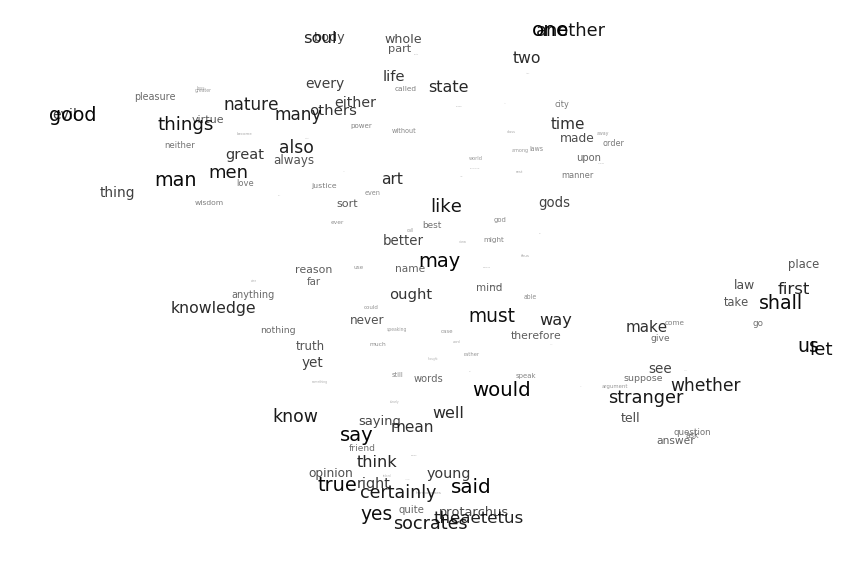

In [24]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

In [25]:
platoW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                alpha=0.025,
                                                window=5,
                                                min_count=5,
                                                hs=0,  #hierarchical softmax toggle
                                                compute_loss = True,
                                               )
platoW2V_loss.build_vocab(plato_df['normalized_sents'].sum())
platoW2V_loss.train(plato_df['normalized_sents'].sum(),
                    total_examples=platoW2V.corpus_count, 
                    epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [platoW2V_loss.running_training_loss]
losses[0]

289473.46875

In [26]:
for i in range(19):
    platoW2V_loss.train(plato_df['normalized_sents'].sum(), 
                        total_examples=platoW2V.corpus_count, 
                        epochs=1,
                             )
    losses.append(platoW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

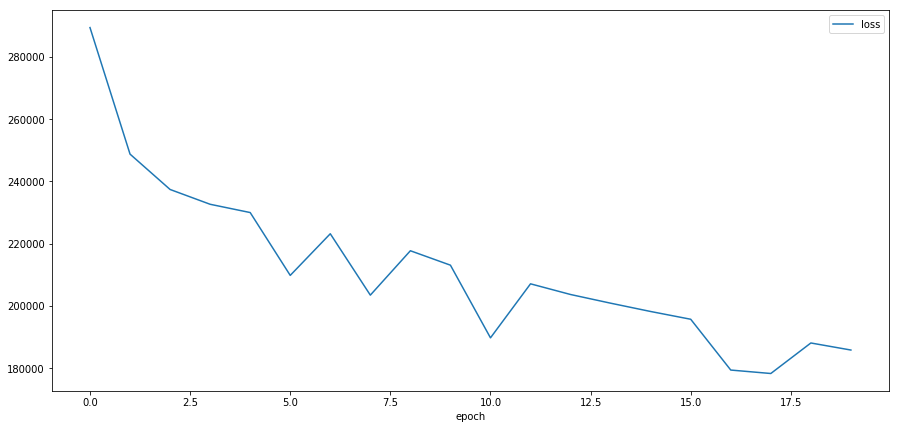

In [27]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

The loss in my text is generally decreasing with the increase of epoch, but is not monotonic in some places. We might use 10 or 16 as my iter.

In [28]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    platoW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    platoW2V_loss_dims.build_vocab(plato_df['normalized_sents'].sum())
    platoW2V_loss_dims.train(plato_df['normalized_sents'].sum(), 
                                   total_examples=platoW2V.corpus_count, 
                                   epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                                  )
    platoW2V_loss_dims.train(plato_df['normalized_sents'].sum(),
                                   total_examples=platoW2V.corpus_count, 
                                   epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                                  )
    
    losses_dims.append(platoW2V_loss_dims.running_training_loss/(10+d*10))

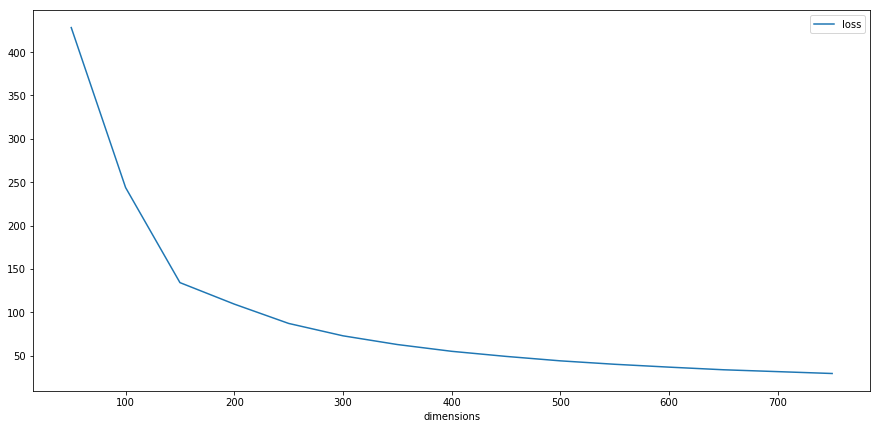

In [29]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

Most of the word distance variation is captured by 400 dimensions.

Before discuss the findings in Plaot's books, I want to say that Plato's writing style (dialogue) causes a lot of obstacle for us. First, when we look at the similar words of a specific word, many trivial conversation words appear. Although in most cases we can identify the meaningful one, it might be hard to tell in some cases. For example, when we look for the similar words of "virtue", too many meaningless words appear so that the only meaningful word in top ten position is "justice". Besides, there are also many trivial conversation words in word cloud graph. I think it has seriously masked many findings.

Despite the negative effects from Plato's writing style, there are also some interesting findings. First, order + virtue - state = justice. This equation proves the explanation that state is, at least to some extent, the metaphor of virtue: order is the internal meaning of the goodness of a state just as justice is the internal meaning of virtue. Second, knowledge is an outlier when it is along with goodness, beauty and justice. In the past, I always think knowledge has the same status as the other three. This result supurises me. Finally, it is hard for us to extract some useful information in the word cloud graph because of too many trival words. But we can still know that Plato like using antonym such as good versus evil, body versus soul, part versus whole and anything versus nothing. The finding of writing style mgiht be also a finding...

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [ ]:
apsD2V.docvecs[1952]

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [30]:
targetDir = '../stage_plato'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path) as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

plato_df = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'stage' : 'stage'})

early = plato_df[0:9].replace('stage', 'early' )

late = plato_df[9:15].replace('stage', 'late' )

middle = plato_df[15:26].replace('stage', 'middle' )


plato_stage = pandas.concat([early, late, middle])

# Remove some features vectors 
remove = np.array(['replied', 'Crito', 'Cleinias', 'Timaeus', 'Protagoras', 'Theaetetus', 'critias',
                   'Phaedrus', 'Phaedo', 'SOCRATES', 'Philebus', 'Parmenides',
                   'Euthyphro', 'Meno', 'Nicias', 'Polus', 'Cratylus', 'Theodorus', 'Menexenus', 
                   'Nicias', 'Ion', 'Dion', 'Simmias', 'Agathon', 'Hellenes', 'Gorgias', '\n', '\t'
                   'theodorus', 'DIALOGUE', 'Athens', 'Athenian', 'Author', 'Athenians', 'THEODORUS'])
       
for i in range(plato_stage.shape[0]):
    for j in range(len(remove)):
        plato_stage["text"].iloc[i] = re.sub(remove[j], ' ', plato_stage["text"].iloc[i])

plato_stage[::3]

,book,stage,text
0,E_Plato_Apology.txt,early,"Apology How you, O s, have been affected by m..."
3,E_Plato_Euthyphro.txt,early,"PERSONS OF THE : Socrates, . SCENE: The P..."
6,E_Plato_Lysis.txt,early,"Lysis, or Friendship PERSONS OF THE : Socrate..."
9,L_Plato_Critias.txt,late,"Critias PERSONS OF THE : Critias, Hermocrates..."
12,L_Plato_Sophist.txt,late,"Sophist PERSONS OF THE : , , Socrates. An E..."
15,M_Plato_Cratylus.txt,middle,"PERSONS OF THE : Socrates, Hermogenes, . ..."
18,M_Plato_Laws.txt,middle,Laws BOOK I PERSONS OF THE : An ATHENIAN STRA...
21,M_Plato_Phaedo.txt,middle,"PERSONS OF THE : , who is the narrator of ..."
24,M_Plato_Symposium.txt,middle,"SYMPOSIUM PERSONS OF THE : Apollodorus, who r..."


In [31]:
keywords = ['law', 'state', 'beauty', 'knowledge', 'city', 'virtue', 'justice', 'eros', 'love', 'socrates']

In [32]:
plato_stage['tokenized_words'] = plato_stage['text'].apply(lambda x: nltk.word_tokenize(x))
plato_stage['normalized_words'] = plato_stage['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [33]:
taggedDocs = []
for index, row in plato_stage.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['stage'])
    docKeywords.append(row['book']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
plato_stage['TaggedText'] = taggedDocs

In [52]:
platoD2V = gensim.models.doc2vec.Doc2Vec(plato_stage['TaggedText'], size = 100) #Limiting to 100 dimensions

In [54]:
platoD2V.docvecs['middle']

array([ 0.09065515,  0.57547635, -0.64571047,  0.6562716 ,  0.33334816,
       -0.4886518 ,  0.3853897 , -0.23653258,  0.7737339 , -0.2697127 ,
        0.5451659 ,  0.28624326, -0.70382917, -0.1408315 , -0.0786427 ,
       -0.8123591 ,  0.42751878,  0.09049241,  0.78930193,  0.26668507,
        0.09397978,  0.00196909, -0.03511842, -0.7235978 ,  0.03723338,
        0.6824334 , -0.48645794, -0.5584363 , -1.1017631 , -0.19761793,
       -0.36670312,  0.4435837 , -0.6284156 , -0.2978277 ,  0.9941424 ,
       -0.7211481 , -0.23592207, -0.6298107 ,  0.3248841 , -0.31805977,
        0.6243348 , -1.0926266 ,  0.4546716 , -0.05829214, -0.30402884,
       -0.09312412, -0.42123008, -0.64669734, -0.6947322 ,  0.08438032,
        0.09206212, -0.06649063, -0.13706887, -0.04377649, -0.09388849,
       -1.0575085 ,  0.28505054,  0.54833233, -0.16750117,  0.22163819,
        0.08432376, -0.10997154, -0.5046465 , -0.05248472, -0.8302933 ,
        0.7794478 , -0.07693574, -1.4178667 , -0.50322056, -1.39

In [55]:
platoD2V.docvecs['justice']

array([-0.35315594, -1.1179286 ,  0.4396771 , -0.29876426,  0.3028216 ,
       -0.24513835,  1.0795676 , -0.93516725, -0.66276956, -0.1320666 ,
        0.06793848, -0.66317135, -0.221419  ,  0.6920128 ,  0.6428942 ,
        0.4833968 , -0.11544874, -0.54095805, -0.18622893,  0.38455832,
        1.0952331 , -0.71026206,  0.33571243,  0.21177308, -0.5090407 ,
       -0.21696097, -0.47613457, -0.3524224 , -0.2885914 , -0.2104684 ,
        0.20836665,  0.65833193, -0.2658414 , -0.46052703,  0.22920375,
       -0.2708753 , -1.1439838 , -0.6835127 ,  0.3936817 ,  0.22798815,
        1.0772153 , -0.12089471, -0.05605239,  0.5240343 , -0.37292102,
       -1.1393964 ,  0.90100867, -0.38840914,  0.29606408, -0.38858342,
        0.6321124 , -0.24244574, -0.42808574,  0.95736074, -0.30008426,
        0.6302384 ,  0.17179386, -0.24960697,  0.29148456,  0.7731843 ,
       -0.82741624, -0.25458032,  0.64913094, -0.41813976,  0.33838868,
        0.37318328, -0.34725866, -0.50802124,  0.28891417,  0.02

In [56]:
platoD2V.most_similar(positive = ['lover','youth'], negative = ['old'], topn = 10)

[('love', 0.9949913024902344),
 ('death', 0.994838297367096),
 ('philosophy', 0.9945446252822876),
 ('greatest', 0.9944584369659424),
 ('return', 0.9934222102165222),
 ('benefit', 0.9932321906089783),
 ('beloved', 0.9931423664093018),
 ('fortune', 0.9929868578910828),
 ('master', 0.9929543733596802),
 ('pleased', 0.9926746487617493)]

Due to Plao's writing style, I look for the meaningful similar words in top 10 instead of the first similar word. Here lover + youth - old = beloved is the most meaningful one since Plato often discusses that the young is the beloved and the old is the lover.

In [57]:
sklearn.metrics.pairwise.cosine_similarity(platoD2V['knowledge'].reshape(1,-1), platoD2V['god'].reshape(1,-1))

array([[0.9820697]], dtype=float32)

In [59]:
platoD2V.docvecs.most_similar([ platoD2V['knowledge'] ], topn=1)

[('E_Plato_Ion.txt', 0.9963274598121643)]

In [60]:
platoD2V.most_similar( [ platoD2V.docvecs['M_Plato_Symposium.txt'] ], topn=10) 

[('youth', 0.983659029006958),
 ('day', 0.9824745655059814),
 ('lead', 0.9813935160636902),
 ('hour', 0.9812929630279541),
 ('away', 0.980365514755249),
 ('children', 0.9800397753715515),
 ('drinking', 0.9800187349319458),
 ('son', 0.9786902666091919),
 ('life', 0.9781539440155029),
 ('among', 0.9765763282775879)]

In [61]:
platoD2V.docvecs.most_similar([platoD2V['eros'] + platoD2V['love'] +
                               platoD2V['beauty'] + platoD2V['drink'] +
                               platoD2V['beloved'] + platoD2V['scene'] +
                               platoD2V['agathon'] + platoD2V['marsyas']], topn=3 )

[('E_Plato_Ion.txt', 0.991119384765625),
 ('E_Plato_Crito.txt', 0.9878851175308228),
 ('E_Plato_Laches.txt', 0.9868569374084473)]

In [62]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = platoD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, platoD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

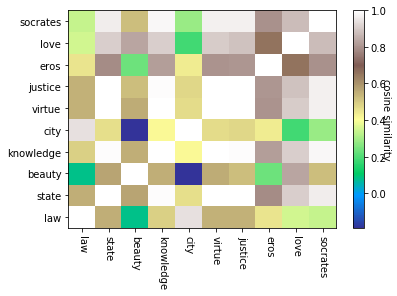

In [63]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [64]:
targetDocs = plato_df['book'][::3]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = platoD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, platoD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

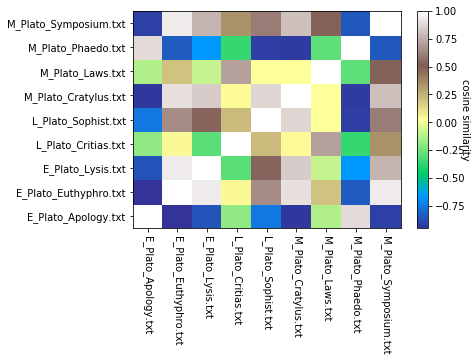

In [65]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [66]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = platoD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, platoD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

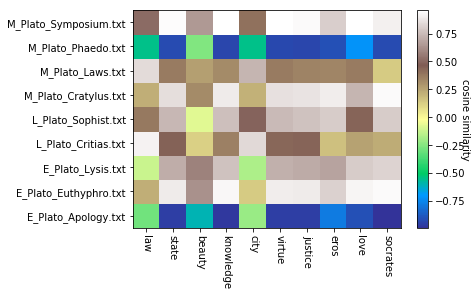

In [67]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [68]:
platoD2V.save('platoW2V')

I randomly select some books respectively from Plato's early, middle and late dialogues. Before the heap matrices, I also compute some relationships between words, documents as well as word and document. The results are consisitent with the common sense. For example, lover + youth - old = beloved is meaningful since Plato often discusses that the young is the beloved and the old is the lover. The interesting results are from heat matrices. In the first graph, we know that Socrates in Plato's dialogue are similar to most important concepts instead of city and and law. This might because these two concepts frequently appear in Plato's late dialogues but it is a common sense that Plato's decrease the frenquency of discussing philosophic topic through Socreates. From the second graph we can know a drawback of this method. Specifically, the heap matrix shows that Plato's topic is based on his individual books rather than the stages since we can not identify the systemic changes based on stages. However, it is not the case when we concern that Plato's attitude and sutle usage of some concepts are changing over time even though he discusses the same philosophical topic. In the third graph we can identify some topics in some books. Symposium contains a large number of topics since many key concepts are similar to this document. On the contrary, Apology and Phaedo are not similar to most concepts.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [ ]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In [185]:
plato_df['tokenized_sents'] = plato_df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
platoW2V = gensim.models.word2vec.Word2Vec(plato_df['tokenized_sents'].sum())

In [186]:
platoWords = ['youth', 'old', 'elder', 'boy', 'boys', 'man', 'men', 'women', 'counsel', 'soldier','children','parent', 'parents', 'philosopher', 'guardians', 'king']
#words we will be mapping
platoWords += ['art', 'medicine', 'citizen', 'prudence', 'vice', 'city', 'state', 'health', 'healthy', "justice","courage","courageous","beauty","beautiful", "true","truth","poem", "education", "music", "art", "temperance","temperate", "knowledge","happiness","pleasure", "wisdom", "wise", "know", "god", "good", "evil"]

wordsSubMatrix = []
for word in platoWords:
    wordsSubMatrix.append(platoW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.30529365, -0.06003341,  0.74995786, ..., -0.69536865,
         0.01574672,  0.26321113],
       [-0.23473015, -0.27899343,  0.62425184, ..., -0.62230057,
         0.30275643,  0.40811884],
       [-0.05354054, -0.0187333 ,  0.13145854, ..., -0.10466717,
         0.31988442,  0.10556494],
       ...,
       [-0.18658601, -0.08457307,  0.22324908, ..., -0.40238848,
         0.3988863 ,  0.33501905],
       [-0.15941569,  0.6426734 ,  0.61164886, ..., -1.7541888 ,
         0.40196496,  1.5912594 ],
       [-0.7688983 ,  0.15263909,  0.47841805, ..., -0.5602511 ,
         0.04092512,  1.7250102 ]], dtype=float32)

In [187]:
pcaWordsplato = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataplato = pcaWordsplato.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsplato = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataplato)

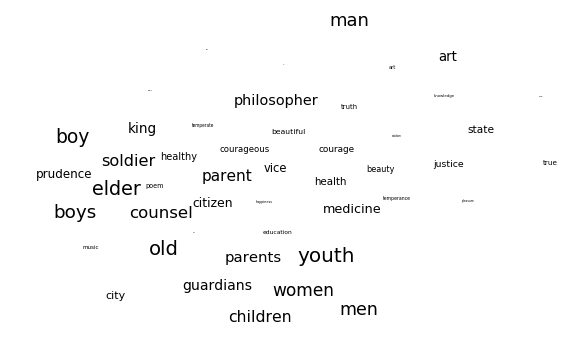

In [188]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsplato[:, 0], tsneWordsplato[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(platoWords):
    ax.annotate(word, (tsneWordsplato[:, 0][i],tsneWordsplato[:, 1][i]), size =  20 * (len(platoWords) - i) / len(platoWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [189]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [190]:
Age = dimension(platoW2V, ['boy','youth','youths', "children", 'young'], ['old', 'men', 'man', 'elder'])
Age_inverse = dimension(platoW2V, ['old', 'men', 'man', 'elder'], ['boy','youth','youths', "children", 'young'])
Gender = dimension(platoW2V, ['man','him','he'], ['woman', 'her', 'she'])
Class = dimension(platoW2V, ['golden', 'silver', 'philosopher', 'rulers'], ['brass', 'iron', 'husbandman', 'artisan'])

In [191]:
Virtue = ['justice', 'prudence', 'honesty', 'courage', 'wisdom', 'beautiful', 'courage', 'temperance', 'knowledge']

Skill = ["music", "poem", "science", "geometry", "lyric", "book", "teacher", "defend", "drink", "philosophy"]

Right  = ["law", "state", "city", "vote", "citizen", "freedom", "household", "speech", "court"]

In [192]:
def makeDF(model, word_list):
    g = []
    a = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(platoW2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        a.append(sklearn.metrics.pairwise.cosine_similarity(platoW2V[word].reshape(1,-1), Age.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(platoW2V[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'age': a, 'class': c}, index = word_list)
    return df

In [193]:
virtue = makeDF(platoW2V, Virtue) 
skill = makeDF(platoW2V, Skill)
right = makeDF(platoW2V, Right)

In [194]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

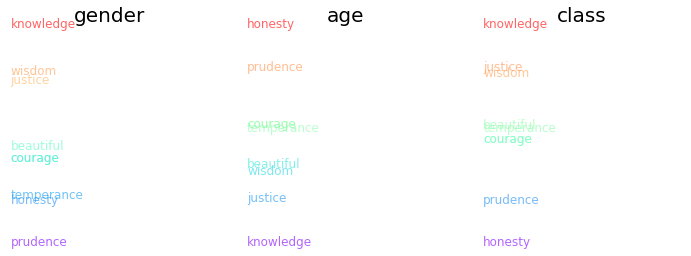

In [195]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, virtue, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, virtue, 'age')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, virtue, 'class')
plt.show()

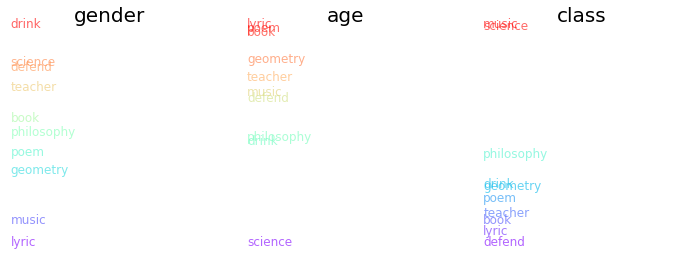

In [196]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, skill, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, skill, 'age')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, skill, 'class')
plt.show()

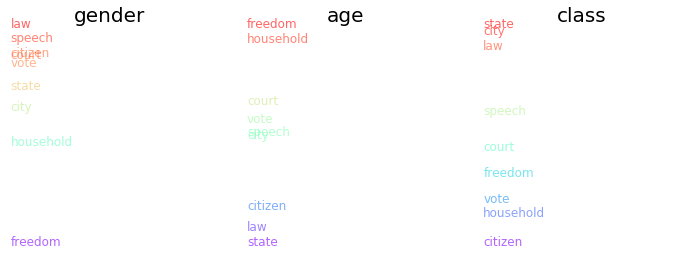

In [197]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, right, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, right, 'age')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, right, 'class')
plt.show()

In [198]:
sklearn.metrics.pairwise.cosine_similarity(Age.reshape(1,-1), Gender.reshape(1,-1))

array([[-0.55134636]], dtype=float32)

In [206]:
sklearn.metrics.pairwise.cosine_similarity(Class.reshape(1,-1), Gender.reshape(1,-1))

array([[0.18021242]], dtype=float32)

In [200]:
sklearn.metrics.pairwise.cosine_similarity(Class.reshape(1,-1), Age.reshape(1,-1))

array([[-0.20540604]], dtype=float32)

In [201]:
sklearn.metrics.pairwise.cosine_similarity(Gender.reshape(1,-1), Age_inverse.reshape(1,-1))

array([[0.55134636]], dtype=float32)

In [ ]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(plato_df),))

s_k =np.array([])
tau_k=np.array([])
for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(plato_df[sample_indices == i]['tokenized_sents'].sum())
    Age = dimension(sample_w2v, ['boy','youth','youths', "children", 'young'], ['old', 'men', 'man', 'elder'])
    Age_inverse = dimension(sample_w2v, ['old', 'men', 'man', 'elder'], ['boy','youth','youths', "children", 'young'])
    Gender = dimension(sample_w2v, ['man','him','he'], ['woman', 'her', 'she'])
    Class = dimension(sample_w2v, ['golden', 'silver', 'philosopher', 'rulers'], ['brass', 'iron', 'husbandman', 'artisan'])
    virtue = makeDF(sample_w2v, Virtue) 
    skill = makeDF(sample_w2v, Skill)
    right = makeDF(sample_w2v, Right)
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, sklearn.metrics.pairwise.cosine_similarity(Gender.reshape(1,-1), Age.reshape(1,-1)))
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(plato_df[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

print("The 90% confidence interval for the cosine distance between justice and virtue is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

I created three dimensions according to a qualitative understanding of Plato's dialogue. The first is gender, the second is age and the third is social class. It is worth noting that Plato divides the socienty into 4 classes. The first two are golden and silver people and the last two are brass and iron people. I projected three set of words incliding political rights, skill and virtue. 

Knowledge is a very different words in Plato's corpus: only the upper class old man can have it! Justice and wisdom are also dominantly masculine, old and upper-class. Generally, 10 virtues are relative separate in all three dimensions. I think this is because Plato insists that different people should have different virtues. When we look at skill, many are clustering together, only science is the outlier: very masculine, old and upper-class. It is interesting that philosophy is relatively neutral in all three dimensions. In the field of skill, it is hard to say which one is very different. As for political rights, its very weird that only freedom is very feminine and most other rights are very masculine. It might confirm that only men have political rights in ancient Greece.

Besides, I also compared the similarity of different dimensions. The most interesting finding is that gender(from men to women) and age (from young to old) are moderately negatively correlated (-0.55). Considering that in Plato's dialogues the young are beloved and the old are lover who take care of the young. We can speculate that young people in Ancient Greece are seen as feminine human being. We can also visually find this conclusion, especially in virtue concepts which is the most important in Plato's dialogue, because the young share many similar virtue with women.

Class dimension don't show much correlation with other two dimensions and thus it is a different dimension.